In [1]:
#Importing libraries needed
import numpy as np
import cv2
import os
import keras
import tensorflow as tf
from skimage import color
import seaborn as sns
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [8]:
# Define the class labels
labels = ['PNEUMONIA', 'NORMAL']

# Seting the image size
img_size =256

# Defining a function to retrieve and preprocess images from a specified data directory
def retrieve_image(data_dir):
    # Create an empty list to store image data and labels
    df = []
    
    # Looping through each class label (e.g., 'PNEUMONIA' and 'NORMAL')
    for label in labels:
        # Constructing the path to the directory containing images for the current class
        path = os.path.join(data_dir, label)
        
        # Assigning a unique class number to the current label
        class_num = labels.index(label)
        
        # Looping through each image in the class directory
        for img in os.listdir(path):
            try:
                # Reading the image in grayscale
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                
                # Resizing the image to the specified size (img_size x img_size)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                
                # Appending the resized image and its corresponding class number to the list
                df.append([resized_arr, class_num])
            except Exception as e:
                # Handling exceptions (e.g., if an image cannot be processed)
                print(f"Error processing image: {e}")
    
    # Converting the list of image data and labels into a numpy array
    return np.array(df)

In [9]:
# Defining the paths to the test and train datasets and retrieve the preprocessed images
test_path = retrieve_image(r"C:\Users\HP\Downloads\chest_xray_2\test")
train_path = retrieve_image(r"C:\Users\HP\Downloads\chest_xray_2\train")

C:\Users\HP\AppData\Local\Temp\ipykernel_13156\2644026697.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(df)


In [10]:
# Creating empty lists to store training and testing data
x_train = []
y_train = []
x_test = []
y_test = []


# Looping through the training dataset (train_path) and extract features and labels
for feature, label in train_path:
    x_train.append(feature)  # Appending the image data (feature) to the training data
    y_train.append(label)    # Append the corresponding label to the training labels
    
# Looping through the testing dataset (test_path) and extract features and labels
for feature, label in test_path:
    x_test.append(feature)    # Appending the image data (feature) to the testing data
    y_test.append(label)      # Appending the corresponding label to the testing labels

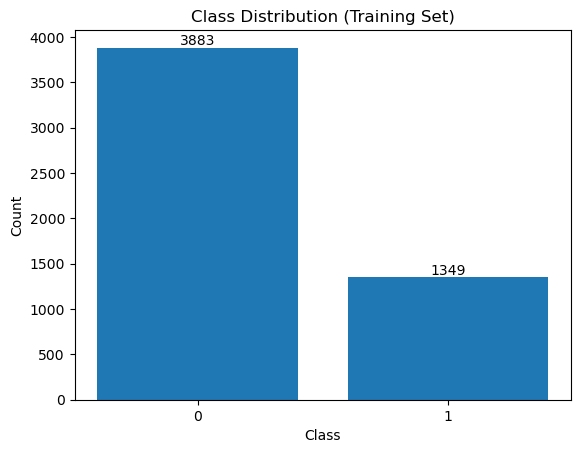

In [11]:
# Counting the occurrences of each class in y_train
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Creating a bar chart
x_values = range(len(unique_classes))  # Specify the x-axis values
class_labels = [str(cls) for cls in unique_classes]  # Convert class labels to strings
plt.bar(x_values, class_counts)

# Setting labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution (Training Set)')

# Setting the x-axis tick positions and labels
plt.xticks(x_values, class_labels)

# Adding labels to the bars
for i, count in enumerate(class_counts):
    plt.text(x_values[i], count, str(count), ha='center', va='bottom')

# Showing the plot
plt.show()

In [12]:
# Checking the shape of the first training data point
x_train[1].shape

(256, 256)

In [14]:
# Normalizing the pixel values by scaling them to the range [0, 1]
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

In [15]:
# Reshaping the training and testing data to have the required input shape for the model
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [16]:
#checking the shape of x_test
x_test.shape

(624, 256, 256, 1)

In [17]:
#checking the shape of x_test
x_train.shape

(5232, 256, 256, 1)

In [18]:
from imblearn.over_sampling import RandomOverSampler

# Flattening the 4D image data to 2D (batch_size, height * width * channels)
x_train_flattened = x_train.reshape(x_train.shape[0], -1)

# Creating and fit the RandomOverSampler
ros = RandomOverSampler(sampling_strategy=1)  # Adjust the sampling_strategy as needed
x_train_resampled, y_train_resampled = ros.fit_resample(x_train_flattened, y_train)

# Reshaping the resampled data back to its original shape
x_train_resampled = x_train_resampled.reshape(x_train_resampled.shape[0], 256, 256, 1)  # Adjust the shape as needed

In [19]:
# Checking the shape of the labels
y_train_resampled.shape

(7766,)

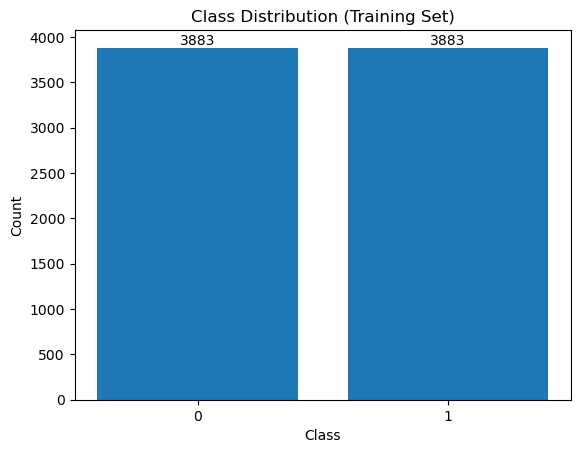

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Counting the occurrences of each class in y_train
unique_classes, class_counts = np.unique(y_train_resampled, return_counts=True)

# Creating a bar chart
x_values = range(len(unique_classes))  # Specify the x-axis values
class_labels = [str(cls) for cls in unique_classes]  # Convert class labels to strings
plt.bar(x_values, class_counts)

# Setting labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution (Training Set)')

# Setting the x-axis tick positions and labels
plt.xticks(x_values, class_labels)

# Adding labels to the bars
for i, count in enumerate(class_counts):
    plt.text(x_values[i], count, str(count), ha='center', va='bottom')

# Showing the plot
plt.show()

In [21]:
#checking x_train shape
x_train_resampled.shape

(7766, 256, 256, 1)

In [22]:
# Counting the number of samples for each class in the balanced dataset
num_class_0_samples_balanced = np.sum(y_train_resampled == 0)
num_class_1_samples_balanced = np.sum(y_train_resampled == 1)

# Printing the counts
print(f"Number of samples in Class 0 (after balancing): {num_class_0_samples_balanced}")
print(f"Number of samples in Class 1 (after balancing): {num_class_1_samples_balanced}")

Number of samples in Class 0 (after balancing): 3883
Number of samples in Class 1 (after balancing): 3883


In [23]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False, 
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=1e-6, 
                             rotation_range=30, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             brightness_range=None,
                             shear_range=0.0,
                             zoom_range=0.2,
                             channel_shift_range=0.0,
                             fill_mode="nearest",
                             cval=0.0,
                             horizontal_flip=True

                            
)

datagen.fit(x_train_resampled)

In [24]:
# Create a Sequential model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(MaxPooling2D((2, 2)))

# Second Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Apply Dropout for regularization
model.add(Dropout(0.5))

# Third Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Apply Dropout for regularization
model.add(Dropout(0.6))

# Additional Convolutional Blocks
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output for the fully connected layers
model.add(Flatten())

# Fully Connected Layer with ReLU activation and L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(2e-0)))

# Apply Dropout for regularization
model.add(Dropout(0.6))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

In [27]:
# Setting the learning rate for the optimizer
learning_rate = 0.00001

# Initializing the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compiling the model with the specified optimizer, loss, and metrics
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Displaying the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

In [28]:
#Training the dataset and validating with test dataset
history = model.fit(
    x_train_resampled,  # Training data
    y_train_resampled,  # Training labels
    batch_size=32,  # Batch size
    epochs=10,  # Number of epochs
    validation_data=(x_test, y_test)  # Validation data and labels
)

Epoch 1/10
243/243 [==============================] - 658s 3s/step - loss: 439.9824 - accuracy: 0.5252 - val_loss: 378.7064 - val_accuracy: 0.6250
Epoch 2/10
243/243 [==============================] - 723s 3s/step - loss: 328.0548 - accuracy: 0.5797 - val_loss: 281.2419 - val_accuracy: 0.6346
Epoch 3/10
243/243 [==============================] - 36547s 151s/step - loss: 242.4816 - accuracy: 0.6280 - val_loss: 206.6977 - val_accuracy: 0.7885
Epoch 4/10
243/243 [==============================] - 613s 3s/step - loss: 177.1310 - accuracy: 0.6657 - val_loss: 149.9245 - val_accuracy: 0.8590
Epoch 5/10
243/243 [==============================] - 757s 3s/step - loss: 127.5322 - accuracy: 0.7098 - val_loss: 107.0467 - val_accuracy: 0.8413
Epoch 6/10
243/243 [==============================] - 869s 4s/step - loss: 90.2550 - accuracy: 0.7578 - val_loss: 75.0474 - val_accuracy: 0.8413
Epoch 7/10
243/243 [==============================] - 617s 3s/step - loss: 62.6174 - accuracy: 0.8014 - val_loss: 51

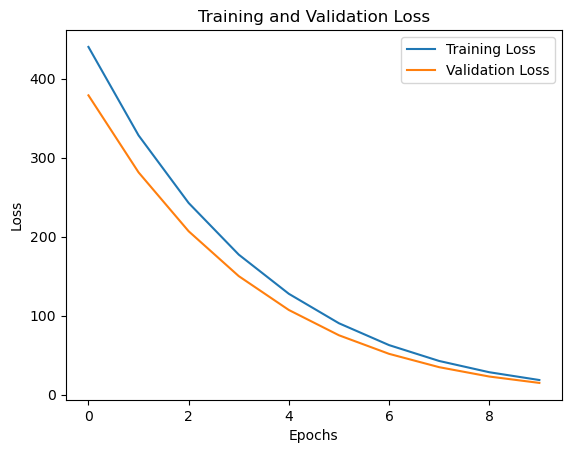

In [29]:
# checking for overfitting

# Ploting training loss against validation loss

#Ploting the training loss as a line with label "Training Loss".
plt.plot(history.history['loss'], label='Training Loss')

#Ploting the validation loss as a line with label "Validation Loss".
plt.plot(history.history['val_loss'], label='Validation Loss')

#Setting the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')

#Setting the label of the x-axis to "Epochs".
plt.xlabel('Epochs')

#Setting the label of the y-axis to "Loss".
plt.ylabel('Loss')

#Showing the legend of the plot with the labels of the two lines.
plt.legend()

#Showing the plot on the screen.
plt.show()

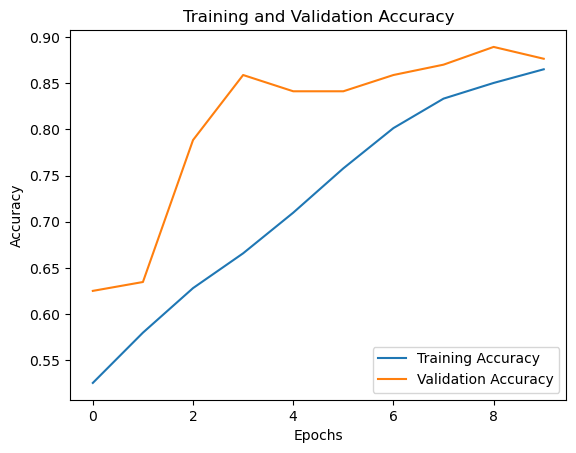

In [30]:
# Plot training and validation accuracy

#Plotting the training accuracy as a line with label "Training Accuracy".
plt.plot(history.history['accuracy'], label='Training Accuracy')

#Plotting the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

#Setting the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')

#Setting the label of the x-axis to "Epochs".
plt.xlabel('Epochs')          

#Setting the label of the y-axis to "Accuracy".
plt.ylabel('Accuracy')

#Showing the legend of the plot with the labels of the two lines.
plt.legend()

#Showing the plot on the screen.
plt.show()

In [39]:
# Obtaining predictions using the trained model on the test dataset
predictions = model.predict(x_test)

# Converting predicted probabilities to binary classes using a threshold of 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Reshaping the array for clarity
predicted_classes = predicted_classes.reshape(1, -1)[0]

# Displaying the first 15 predicted classes
predicted_classes[:15]

20/20 [==============================] - 6s 322ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
# Printing classification report for the test dataset comparing actual and predicted classes
print(classification_report(y_test, predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.86      0.96      0.91       390
   Normal (Class 1)       0.92      0.73      0.82       234

           accuracy                           0.88       624
          macro avg       0.89      0.85      0.86       624
       weighted avg       0.88      0.88      0.87       624



In [42]:
#getting the confusion matrix 
cm = confusion_matrix(y_test,predicted_classes)
cm

array([[376,  14],
       [ 63, 171]], dtype=int64)

In [44]:
#plotting confusion matrix
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

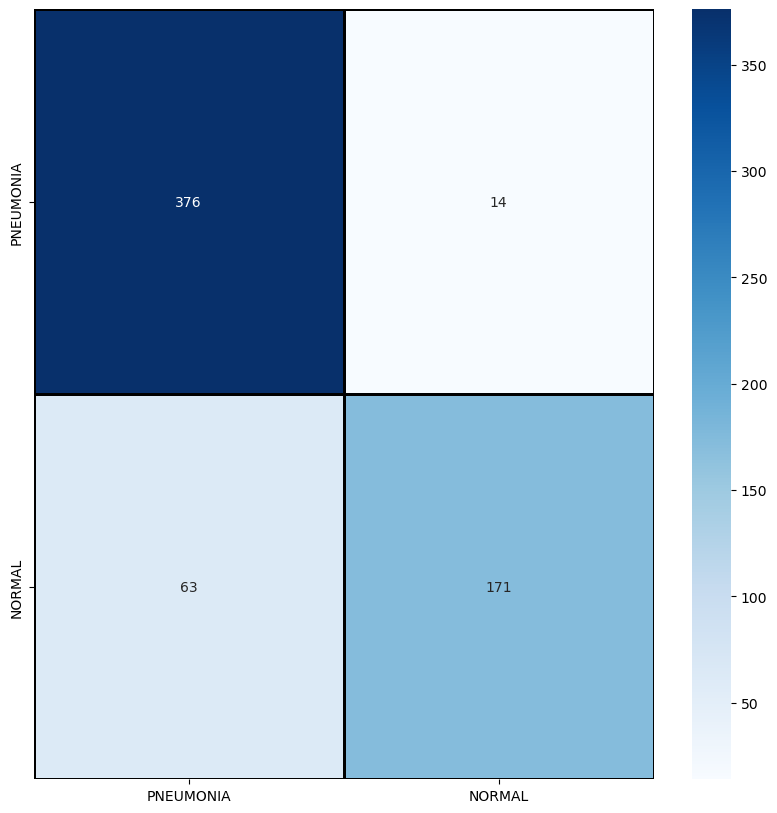

In [45]:
#plotting confusion matrix
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)